In [37]:
import pandas as pd
import seaborn as sns

In [33]:
def string2range(x):
    
    """
    This function takes in a `string` representing a region of interest in a
    protein. The region of interest can be a single region or multiple regions
    of a protein. Returns a range for single regions or a list of ranges for
    multiple regions.
    
    Parameters:
    
        x (string): String containing a region or several regions of interest in a 
            protein.
            Format of x: single region -> 'start-end'
                         multiple regions -> 'start1-end1,start2-end2'
                     
    Returns:
    
        range or list of ranges: For single region proteins a range is returned. For 
            multiple region proteins a list of ranges is returned

            Format: single region -> range(start, end+1)
                    multiple region -> [range(start1, end1+1), range(start2, end2+1)]
    """
    # Handle instances with more than one range
    if ',' in x:
        list_temp = x.split(sep = ',') #list_temp = ['123-456,' '789-1111']
        for y in range(len(list_temp)): 
            list_temp[y] = list_temp[y].split(sep = '-') #list_temp[y] = [['123', '456'], ['789', '1111']]
        for y in range(len(list_temp)): 
            for x in range(len(list_temp[y])):
                list_temp[y][x] = int(list_temp[y][x]) #turns each list item into an integer

        # Make sure the first value of the second list item is greater than the first value of the first list item,
        # and swap them if they are not
        if list_temp[1][0] < list_temp[0][0]:
            list_temp[0], list_temp[1] = list_temp[1], list_temp[0]

        return list_temp

    # Handle instances with only one range
    else:
        list_temp = x.split(sep = '-')
        for y in range(len(list_temp)):
            list_temp[y] = int(list_temp[y]) #

        # Make a range object with the bounds of the region. Note to the 
        # end a 1 has to be added in order to include the last position in the range
        return list_temp
    
def linker_length(region_1, region_2):
    '''
    Each region is a string denoting the bounds of that region. Sometimes, one of the regions is between the other region.
    We want to calculate the linker length between the two regions. The linker length is the number of residues between
    the two regions. '''

    # Case where the region 1 is between region 2
    r1range = string2range(region_1)
    r2range = string2range(region_2)

    if ',' in region_1 and ',' not in region_2:
        if r2range[0] > r1range[0][1] and r2range[1] < r1range[1][0]:
            linker_1 = r2range[0] - r1range[0][1]
            linker_2 = r1range[1][0] - r2range[1]
            linker_length = linker_1 + linker_2
            return linker_length
    elif ',' in region_2 and ',' not in region_1:
        if r1range[0] > r2range[0][1] and r1range[1] < r2range[1][0]:
            linker_1 = r1range[0] - r2range[0][1]
            linker_2 = r2range[1][0] - r1range[1]
            linker_length = linker_1 + linker_2
            return linker_length
    elif ',' in region_1 and ',' in region_2:
        if r1range[0][0] > r2range[1][1]:
            linker_length = r1range[0][0] - r2range[1][1]
            return linker_length
        elif r2range[0][0] > r1range[1][1]:
            linker_length = r2range[0][0] - r1range[1][1]
            return linker_length
    elif len(r1range) == 3 or len(r2range) == 3:
        linker_length = 0
        return linker_length
    else:
        if r1range[0] > r2range[1]:
            linker_length = r1range[0] - r2range[1]
            return linker_length
        elif r2range[0] > r1range[1]:
            linker_length = r2range[0] - r1range[1]
            return linker_length
    

In [34]:
ai = pd.read_csv('./project_pipeline/data/classified_files.tsv', sep='\t')
md = pd.read_csv('./project_pipeline/data/md_rmsds.tsv', sep='\t')

In [30]:
# # Find rows where the region_1_range is a list with three elements
# ai['region_1_range_len'] = ai['region_1_range'].apply(lambda x: len(x) if type(x) == list else 1)
# ai['region_2_range_len'] = ai['region_2_range'].apply(lambda x: len(x) if type(x) == list else 1)

,uniprot,pdb,region_1,region_2,complex_rmsd,percent_region_1,percent_region_2,2_aligned,2_comp,state,conformation,organism,date,notes,chain,af_filename,region_1_range,region_2_range,region_1_range_len,region_2_range_len
761,Q14674,7nj0,"711-723,955-974,1393-1400","667-1706,1707-2120",5.868,75.609756,75.997249,4.668,5.274,NaN,Closed,Homo sapiens,['2021-02-14'],NaN,A,F-Q14674-F1-model_v3.cif,"[[711, 723], [955, 974], [1393, 1400]]","[[667, 1706], [1707, 2120]]",3,2


In [35]:

ai['linker_length'] = ai.apply(lambda x: linker_length(x['region_1'], x['region_2']), axis=1)
md['linker_length'] = md.apply(lambda x: linker_length(x['region_1'], x['region_2']), axis=1)

In [42]:
ai['type'] = 'AI'
md['type'] = 'MD'

df = pd.concat([ai, md])
df.head()

,uniprot,pdb,region_1,region_2,complex_rmsd,percent_region_1,percent_region_2,2_aligned,2_comp,state,...,2.1_aligned,2.1_comp,2.2_aligned,2.2_comp,2.3_aligned,2.3_comp,gt_fn,complex_fn,1_aligned,1_comp
0,P04637,8f2h,364-393,102-292,30.431,100.0,100.0,3.065,70.729,Autoinhibited,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P04637,8f2i,364-393,102-292,30.431,100.0,100.0,3.065,70.729,Autoinhibited,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P07038,1mhs,892-917,562-625,14.225,100.0,100.0,8.246,22.815,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,P07038,7nxf,892-917,562-625,4.914,100.0,100.0,1.812,12.107,Autoinhibited,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,P07038,7ny1,892-917,562-625,4.914,100.0,100.0,1.812,12.107,Autoinhibited,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


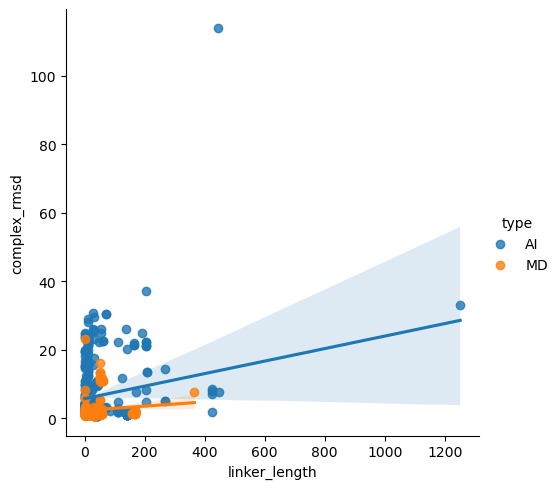

In [44]:
sns.lmplot(data=df, x='linker_length', y='complex_rmsd', hue='type')

In [45]:
sub = df[['linker_length', 'complex_rmsd', 'type']]
sub.corr()

/tmp/ipykernel_1831403/1425505238.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sub.corr()


,linker_length,complex_rmsd
linker_length,1.000000,0.156288
complex_rmsd,0.156288,1.000000


In [46]:
ai.corr()

/tmp/ipykernel_1831403/998784478.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  ai.corr()


,complex_rmsd,percent_region_1,percent_region_2,2_aligned,2_comp,linker_length
complex_rmsd,1.000000,-0.084572,0.165710,0.394406,0.941930,0.173907
percent_region_1,-0.084572,1.000000,-0.054549,-0.046727,-0.105036,0.041878
percent_region_2,0.165710,-0.054549,1.000000,-0.131529,0.211954,-0.060570
2_aligned,0.394406,-0.046727,-0.131529,1.000000,0.348655,0.147904
2_comp,0.941930,-0.105036,0.211954,0.348655,1.000000,0.209547
linker_length,0.173907,0.041878,-0.060570,0.147904,0.209547,1.000000


In [47]:
md.corr()

/tmp/ipykernel_1831403/3550572334.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  md.corr()


,complex_rmsd,1.0_aligned,1.0_comp,1.1_aligned,1.1_comp,1.2_aligned,1.2_comp,2.0_aligned,2.0_comp,2.1_aligned,...,2.2_comp,2.3_aligned,2.3_comp,percent_region_1,percent_region_2,1_aligned,1_comp,2_aligned,2_comp,linker_length
complex_rmsd,1.000000,0.158956,0.850953,-0.015377,0.060034,-0.003659,0.060884,0.160289,0.841385,NaN,...,NaN,NaN,NaN,-0.088817,-0.212218,0.163055,0.856761,0.160289,0.841385,0.101780
1.0_aligned,0.158956,1.000000,0.086539,-0.282050,-0.158726,-0.272194,-0.156241,0.131577,0.064045,NaN,...,NaN,NaN,NaN,-0.150878,-0.047573,0.974969,0.065356,0.131577,0.064045,-0.182334
1.0_comp,0.850953,0.086539,1.000000,-0.084038,-0.047293,-0.081101,-0.046553,0.168948,0.962977,NaN,...,NaN,NaN,NaN,-0.073088,-0.230490,0.070786,0.991129,0.168948,0.962977,0.211945
1.1_aligned,-0.015377,-0.282050,-0.084038,1.000000,0.712435,0.988195,0.705284,-0.081371,-0.015931,NaN,...,NaN,NaN,NaN,-0.091109,0.015245,-0.062431,0.010506,-0.081371,-0.015931,-0.116614
1.1_comp,0.060034,-0.158726,-0.047293,0.712435,1.000000,0.784007,0.999937,-0.019040,0.035564,NaN,...,NaN,NaN,NaN,-0.086135,-0.006579,0.009164,0.085882,-0.019040,0.035564,-0.065626
1.2_aligned,-0.003659,-0.272194,-0.081101,0.988195,0.784007,1.000000,0.777564,-0.074084,-0.008161,NaN,...,NaN,NaN,NaN,-0.093633,0.012033,-0.052048,0.023004,-0.074084,-0.008161,-0.112539
1.2_comp,0.060884,-0.156241,-0.046553,0.705284,0.999937,0.777564,1.000000,-0.018040,0.036167,NaN,...,NaN,NaN,NaN,-0.085685,-0.006968,0.010173,0.086620,-0.018040,0.036167,-0.064598
2.0_aligned,0.160289,0.131577,0.168948,-0.081371,-0.019040,-0.074084,-0.018040,1.000000,0.076508,NaN,...,NaN,NaN,NaN,0.039224,-0.108219,0.118742,0.166037,1.000000,0.076508,0.621823
2.0_comp,0.841385,0.064045,0.962977,-0.015931,0.035564,-0.008161,0.036167,0.076508,1.000000,NaN,...,NaN,NaN,NaN,-0.092307,-0.256847,0.063809,0.965219,0.076508,1.000000,0.092648
2.1_aligned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
